### Obtaining Testing and Training data

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_text as text
import tensorflow_hub as hub
from tf_keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

np.random.seed(42)
tf.random.set_seed(42)

df = pd.read_csv("../train.csv")
df = df.drop("qid", axis=1)

In [ ]:
df.head()

## Train and Validation split

In [2]:
train_df, val_df = train_test_split(df, train_size=0.01, test_size=0.001, stratify=df.target.values)
x_train, y_train = train_df["question_text"].values, train_df["target"].values
x_val, y_val = val_df["question_text"].values, val_df["target"].values

X_test = pd.read_csv("../test.csv")
x_test = X_test["question_text"]

x_test.shape

(375806,)

## Download BERT

In [3]:
preprocessor = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4", trainable=True)

## Processing Data

In [4]:
import tf_keras as keras

text_input = keras.layers.Input(shape=(), dtype=tf.string)

encoder_inputs = preprocessor(text_input)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]

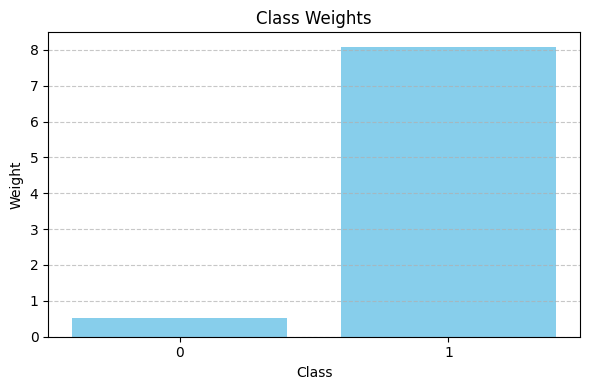

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classWeights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

classWeightDict = dict(enumerate(classWeights))
plt.figure(figsize=(6, 4))
plt.bar(classWeightDict.keys(), classWeightDict.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Weight')
plt.title('Class Weights')
plt.xticks(list(classWeightDict.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Model Definition

In [6]:
x = keras.layers.Dropout(0.5, name="dropout-1")(pooled_output)
x = keras.layers.Dense(16, activation='relu', name="dense-16")(x)

output = keras.layers.Dense(1, activation ='sigmoid', name="output")(x)

model = keras.Model(inputs = [text_input], outputs = [output])
model.compile(
    optimizer=keras.optimizers.Adam(
    learning_rate=2e-5), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

## Training

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.5, patience=2, 
    min_lr=1e-6, 
    verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    verbose=1,
    class_weight=classWeightDict,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
# Get the history values for accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create two subplots: one for accuracy and one for loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot training and validation accuracy
ax1.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy', color='blue')
ax1.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='orange')
ax1.set_title('Training and Validation Accuracy over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot training and validation loss
ax2.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss', color='blue')
ax2.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
ax2.set_title('Training and Validation Loss over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

## Prediction and Test Accuracy

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Predictions
y_pred_probs = model.predict(x_val).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Print Classification Report
print("Classification Report:\n", classification_report(y_val, y_pred))

# Create a bar chart for precision, recall, F1-score, and accuracy
metrics = [precision, recall, f1, accuracy]
metric_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(metric_names, metrics, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.show()

## Confusion Matrix

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

## Submission

In [ ]:
def submit():
    submission = X_test[['qid']].copy()
    prediction = model.predict(x_test)
    pred = (prediction > 0.5).astype(int)
    submission['prediction'] = pred
    submission.to_csv('submission.csv', index=False)
    return submission

submit()